In [1]:
import timm
import torch
import torchmetrics
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import lightning as L
import random
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn as nn

from tqdm import tqdm
from pathlib import Path
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from lightning.pytorch.callbacks import ModelCheckpoint
from copy import deepcopy
from timm.loss import SoftTargetCrossEntropy

from torchvision.datasets import CIFAR100
import torchvision
from torchmetrics import MetricCollection
from torchmetrics.classification import (
    MulticlassAccuracy,
    MulticlassF1Score,
    MulticlassAUROC,
)
import glob

from IPython import get_ipython


def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)


set_seed()
L.seed_everything(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Seed set to 42


In [2]:
%load_ext tensorboard

In [10]:
class alb_transform:
    def __init__(self,transform):
        self.transform = transform
    
    def __call__(self, img):
        img = np.array(img)
        return self.transform(image = img)['image']
    
train_transform = A.Compose([
    A.RandomRotate90(p = 0.3),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.7),
    A.RandomBrightnessContrast(p=0.5),
    A.RGBShift(p=0.2),
    A.GaussianBlur(p=0.3),
    A.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761]),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761]),
    ToTensorV2(),
    
])

full_train_dataset = CIFAR100(root='./data',train=True,download=False)

train_dataset = deepcopy(full_train_dataset)
val_dataset   = deepcopy(full_train_dataset)

train_dataset.transform = alb_transform(train_transform)
val_dataset.transform = alb_transform(test_transform)

generator = torch.Generator().manual_seed(42)
train_idx, val_idx = torch.utils.data.random_split(
    range(len(full_train_dataset)), [45000, 5000], generator=generator
)

train_set = torch.utils.data.Subset(train_dataset, train_idx.indices)
val_set   = torch.utils.data.Subset(val_dataset, val_idx.indices)

test_set =  CIFAR100(root='./data',train=False,download=False,transform=alb_transform(test_transform))


C:\Users\Andruxa\AppData\Local\Temp\ipykernel_9976\2490963622.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  img = np.array(img_pil).transpose(1,2,0)


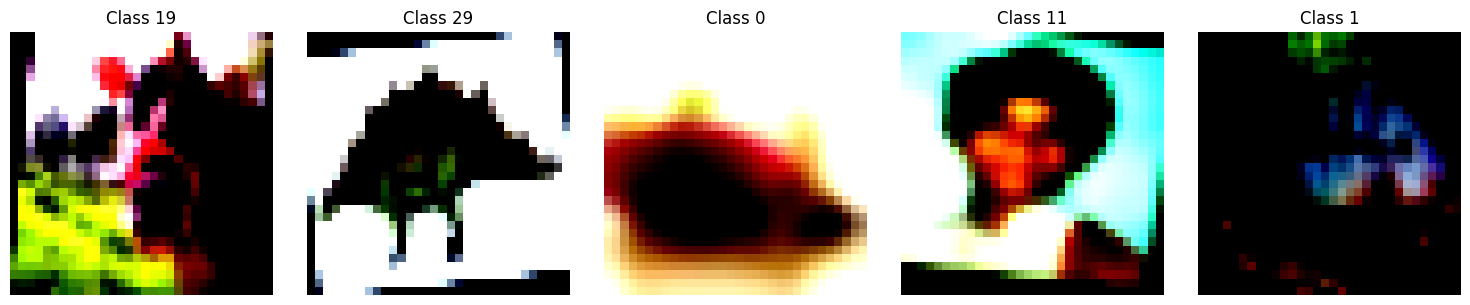

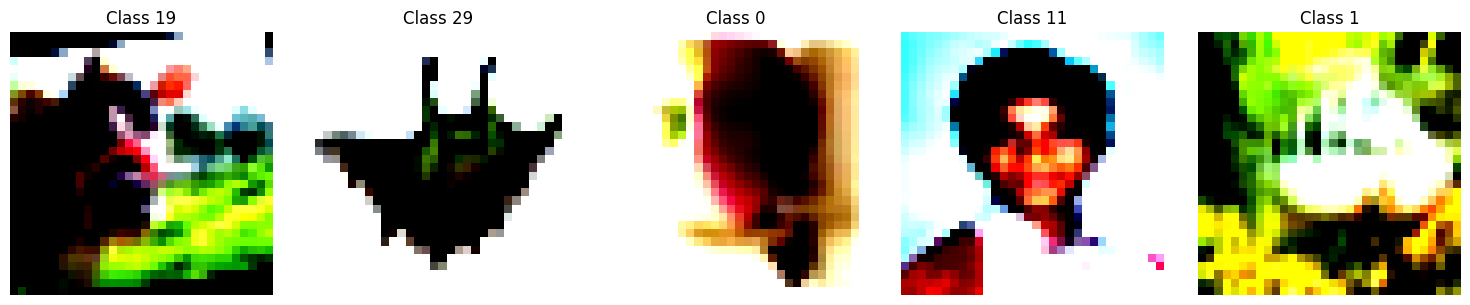

In [21]:
def show_augmented_batch(dataset, n=5):
    mean=np.array([0.5071, 0.4867, 0.4408])
    std=np.array([0.2675, 0.2565, 0.2761])
    fig, axs = plt.subplots(1, n, figsize=(15, 3))
    for i in range(n):
        img_pil, label = dataset[i]
        img = np.array(img_pil).transpose(1,2,0)
        img = np.clip(img, 0, 1)
        axs[i].imshow(img)
        axs[i].set_title(f"Class {label}")
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

show_augmented_batch(train_set.dataset,  n=5)
show_augmented_batch(train_set.dataset,  n=5)

In [23]:
train_loader = DataLoader(train_set.dataset, batch_size=256,shuffle=True)
val_loader = DataLoader(val_set.dataset, batch_size=256, shuffle=False)
test_loader =  DataLoader(test_set, batch_size=256,shuffle=False)

In [24]:
def count_parameters(model):
    num_params = sum(p.numel() for p in model.parameters())
    return num_params
def count_nonzero_parameters(model):
    nonzero_params = sum((p != 0).sum().item() for p in model.parameters() if p.requires_grad)
    return nonzero_params

def count_nonzero_parameters_in_layers(model):
    count = 0
    for module in model.modules():
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            for param in module.parameters():
                if param.requires_grad:
                    count += torch.count_nonzero(param).item()
    return count

In [25]:
class LModel(L.LightningModule):
    def __init__(self, model, lr=0.001,optimizer_cls=torch.optim.AdamW):
        super().__init__()
        self.save_hyperparameters(logger=False, ignore=["model"])
        self.lr = lr
        self.model = model
        self.criterion = nn.CrossEntropyLoss()
        metrics = MetricCollection([
            MulticlassAccuracy(num_classes=100,),
            MulticlassF1Score(num_classes=100,),
        
        ])
        self.train_metrics = metrics.clone(postfix="/train")
        self.val_metrics = metrics.clone(postfix="/val")
        self.test_metrics = metrics.clone(postfix="/test")
        self.optimizer_cls = optimizer_cls

    def configure_optimizers(self):
        optimizer = self.optimizer_cls(
            self.model.parameters(),
            lr=self.lr,
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch", 
                "monitor": "loss"
            },
        }

    def training_step(self, batch, batch_idx):
        x,y = batch
        out = self.model(x)
        loss = self.criterion(out, y)
        self.train_metrics.update(out, y)
        self.log("loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        self.val_metrics.update(out, y)

    def on_train_epoch_end(self):
        self.log_dict(self.train_metrics.compute())
        self.train_metrics.reset()

        val_metrics = self.val_metrics.compute()
        self.log_dict(val_metrics)
        self.val_metrics.reset()

    def test_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        self.test_metrics.update(out, y)

    def on_test_epoch_end(self):
        self.log_dict(self.test_metrics.compute())
        self.test_metrics.reset()


def train_model(model,log_save_dir,exp_name,max_epochs = 10,monitor="MulticlassAccuracy/val",
                return_lightning_model = True,opt_cls = torch.optim.AdamW,lr=1e-3):
    checkpoint_callback = ModelCheckpoint(
        monitor=monitor, mode="max", filename="model"
    )
    pl_model = LModel(model,optimizer_cls = opt_cls,lr = lr)
    trainer = L.Trainer(
        max_epochs=max_epochs,
        callbacks=[checkpoint_callback],
        num_sanity_val_steps=0,
        log_every_n_steps=10,
        logger=L.pytorch.loggers.TensorBoardLogger(save_dir=log_save_dir,name=exp_name),
        enable_progress_bar=True,
        precision="16-mixed"
    )
    trainer.fit(model = pl_model,train_dataloaders=train_loader,val_dataloaders=val_loader)
    if return_lightning_model:
        return pl_model
    else:
        return pl_model.model
    
def test_model(model,lightning_model=False):
    pl_model = model
    if not lightning_model:
        pl_model = LModel(model)
    trainer = L.Trainer(
        enable_progress_bar=True,
        precision="16-mixed"
    )   
    res = trainer.test(pl_model,dataloaders=test_loader)
    return res

    


In [26]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels,out_channels,kernel_size=3,stride = 1,downsample=None):  # You can add params here
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = downsample

    def forward(self, x):
        x_init = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            x_init = self.downsample(x_init)
        out += x_init
        out = self.relu(out)
        return out

class CustomResnet(nn.Module):
    def __init__(self, class_nums=100,input_shape = (3,32,32)):
        super(CustomResnet, self).__init__()
        self.in_chans = 64
        self.conv1 = nn.Conv2d(3,64,kernel_size=1,stride=1,bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()

        self.layer1 = self.create_layers(64)
        self.layer2 = self.create_layers(128)
        self.layer3 = self.create_layers(256)
        self.layer4 = self.create_layers(512)

        self.dropout = nn.Dropout(p=0.3)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512,class_nums)

    def create_layers(self,out_chans,block = BasicBlock,num_blocks=2,stride=1):
        downsample = None
        if stride != 1 or self.in_chans != out_chans:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_chans,out_chans,kernel_size=1,stride=stride,bias=False),
                nn.BatchNorm2d(out_chans)
            )

        layers = []
        for i in range(num_blocks):
            if i == 0:
                layers.append(block(self.in_chans,out_chans,stride = stride,downsample=downsample))
                self.in_chans = out_chans
            else:
                layers.append(block(out_chans,out_chans))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = self.dropout(x)
        x = torch.flatten(x,1)
        x = self.fc(x)
        return x


In [28]:
import torch.nn.utils.prune as prune

def apply_pruning(model,params_num,pruning_method = prune.L1Unstructured, structured=False, n=2, dim=0):
    params_num_total = count_parameters(model)
    prune_ratio = 1-params_num/params_num_total
    parameters_to_prune = []
    for module in model.modules():
        if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
            parameters_to_prune.append((module, 'weight'))
    
    if structured:
         for module, name in parameters_to_prune:
            prune.ln_structured(module, name=name, amount=prune_ratio, n=n, dim=dim)
            prune.remove(module, name)
         for name, param in model.named_parameters():
            if torch.count_nonzero(param) == 0:
                param.requires_grad = False
    else:
        prune.global_unstructured(
            parameters_to_prune,
            pruning_method=pruning_method,
            amount=prune_ratio,
        )
        
        for module, _ in parameters_to_prune:
            prune.remove(module, 'weight')
        for name, param in model.named_parameters():
            if torch.count_nonzero(param) == 0:
                param.requires_grad = False

    return model

In [29]:
from ranger21 import Ranger21  
from functools import partial

def my_optimizer_ranger(params, num_epochs=1, num_batches_per_epoch=len(train_loader), lr=1e-3):
    return Ranger21(params, lr=lr, num_epochs=num_epochs, num_batches_per_epoch=num_batches_per_epoch)

In [30]:
print(my_optimizer_ranger)

<function my_optimizer_ranger at 0x0000024D36F2FAC0>


In [75]:
def training_pipeline(base_model,base_model_name,max_epochs_base,max_epochs_par,par_nums = [1000, 5000, 10000, 50000, 100000, 500000, 1000000],
                      pruning_method = prune.L1Unstructured,opt_cls = torch.optim.AdamW,
                      lr =1e-3,opt_class_name="adamw",base_model_not_calculated=True,structured=False, n=2, dim=0):
    opt_cls_train_base = opt_cls
    opt_cls_train_par = opt_cls
    if opt_cls =='ranger21':
        opt_cls_train_base = partial(my_optimizer_ranger, num_epochs=max_epochs_base)
        opt_cls_train_par = partial(my_optimizer_ranger, num_epochs=max_epochs_par)
    base_model = base_model
    if base_model_not_calculated:
        base_model = train_model(base_model,log_save_dir = f'./saved_models/{base_model_name}/{opt_class_name}',
                    exp_name = 'full_model',return_lightning_model=False,max_epochs=max_epochs_base,opt_cls = opt_cls_train_base,lr = lr)
    else:
        model_dir = f'./saved_models/{base_model_name}/{opt_class_name}/'
        base_mod_dir = model_dir+"full_model/"
        version_model = glob.glob(base_mod_dir+'*/*/model.ckpt')[-1]
        base_model = LModel.load_from_checkpoint(version_model,model=base_model).model
    for par_num in par_nums:
        model_par = apply_pruning(base_model,par_num,pruning_method=pruning_method,structured=structured, n=n, dim=dim)
        model_par = train_model(model_par,log_save_dir = f'./saved_models/{base_model_name}/{opt_class_name}',
                                exp_name = f'{par_num:.0f}_pars',max_epochs=max_epochs_par,opt_cls = opt_cls_train_par,lr = 5*lr/10)

def test_pipeline(backbone,base_model_name,par_nums = [1000, 5000, 10000, 50000, 100000, 500000, 1000000],opt_class_name="adamw"):
    model_dir = f'./saved_models/{base_model_name}/{opt_class_name}/'
    test_accs = []
    for par_num in par_nums:
        par_mod_dir = model_dir+f'{par_num:.0f}_pars/'
        print(par_mod_dir)
        print(par_mod_dir+'*/*/model.ckpt')
        version_model = glob.glob(par_mod_dir+'*/*/model.ckpt')[-1]
        print(version_model)
        par_mod = LModel.load_from_checkpoint(version_model,model=backbone)
        test_res = test_model(par_mod,lightning_model=True)
        test_accs.append(test_res[0]['MulticlassAccuracy/test'])
    return test_accs

def test_pipeline_full_models(backbones,base_model_names,opt_class_name = 'adamw'):
    test_accs = dict()
    for backbone,base_model_name in zip(backbones,base_model_names):
        print(base_model_name)
        model_dir = f'./saved_models/{base_model_name}/{opt_class_name}/'
        base_mod_dir = model_dir+f'full_model/'
        print(base_mod_dir+'*/*/model.ckpt')
        version_model = glob.glob(base_mod_dir+'*/*/model.ckpt')[-1]
        base_mod = LModel.load_from_checkpoint(version_model,model=backbone)
        test_res = test_model(base_mod,lightning_model=True)
        test_accs[base_model_name] = (test_res[0]['MulticlassAccuracy/test'])
    return test_accs


# def test_pipeline(backbone,base_model_name,par_nums = [1000, 5000, 10000, 50000, 100000, 500000, 1000000],opt_class_name="adamw"):
#     model_dir = f'./saved_models/{base_model_name}/{opt_class_name}/'
#     test_accs = []
#     for par_num in par_nums:
#         par_mod_dir = model_dir+f'{par_num:.0f}_pars/'
#         version_model = glob.glob(par_mod_dir+'*/*/model.ckpt')[-1]
#         ckpt = torch.load(version_model, map_location="cpu")
#         state_dict = ckpt["state_dict"]
#         par_mod = backbone.load_state_dict(state_dict, strict=False)
#         test_res = test_model(par_mod,lightning_model=False)
#         test_accs.append(test_res[0]['MulticlassAccuracy/test'])
#     return test_accs

def plot_losses_accs(base_model_name,port):
    log_dir = f'./saved_models/{base_model_name}'
    port = f'{port:.0f}'
    get_ipython().run_line_magic('tensorboard', f'--logdir {log_dir} --port {port}')
        
        
def training_pipeline_extended(models,max_epochs_base,max_epochs_par,par_nums = [1000, 5000, 10000, 50000, 100000],opt_cls = torch.optim.AdamW,lr =1e-3,opt_class_name="adamw"):
    opt_cls_train_par = opt_cls
    for par_num in par_nums:
        for mod in models[f'par_num:.0f']:
            training_pipeline(mod,mod.__name__,max_epochs_base,max_epochs_par,par_nums = [par_num],pruning_method = prune.L1Unstructured,opt_cls = torch.optim.AdamW,lr =1e-3,opt_class_name="adamw")



In [11]:
def load_pretrained_weights_resnet(custom_model, pretrained_model):

    custom_layers = [
        custom_model.layer1,
        custom_model.layer2,
        custom_model.layer3,
        custom_model.layer4
    ]

    pretrained_layers = [
        pretrained_model.layer1,
        pretrained_model.layer2,
        pretrained_model.layer3,
        pretrained_model.layer4
    ]
    for c_layer, p_layer in zip(custom_layers, pretrained_layers):
        for c_block, p_block in zip(c_layer, p_layer):
            c_block.conv1.weight.data.copy_(p_block.conv1.weight.data)
            c_block.bn1.weight.data.copy_(p_block.bn1.weight.data)
            c_block.bn1.bias.data.copy_(p_block.bn1.bias.data)

            c_block.conv2.weight.data.copy_(p_block.conv2.weight.data)
            c_block.bn2.weight.data.copy_(p_block.bn2.weight.data)
            c_block.bn2.bias.data.copy_(p_block.bn2.bias.data)

            if c_block.downsample and p_block.downsample:
                for c_down, p_down in zip(c_block.downsample, p_block.downsample):
                    if isinstance(c_down, nn.Conv2d):
                        c_down.weight.data.copy_(p_down.weight.data)
                    elif isinstance(c_down, nn.BatchNorm2d):
                        c_down.weight.data.copy_(p_down.weight.data)
                        c_down.bias.data.copy_(p_down.bias.data)
    return custom_model

In [15]:
from torchvision.models import resnet18
model = CustomResnet()
pre_trained_resnet = resnet18(pretrained = True)
model = load_pretrained_weights_resnet(model,pre_trained_resnet)
training_pipeline(model,'resnet18',max_epochs_base=20,max_epochs_par=10)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | CustomResnet     | 11.2 M | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.874    Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | CustomResnet     | 11.2 M | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.874    Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | CustomResnet     | 11.2 M | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.874    Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | CustomResnet     | 11.2 M | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.874    Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | CustomResnet     | 11.2 M | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.874    Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | CustomResnet     | 11.2 M | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.874    Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | CustomResnet     | 11.2 M | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.874    Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | CustomResnet     | 11.2 M | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.874    Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [14]:
from torchvision.models import resnet18
model = CustomResnet()
pre_trained_resnet = resnet18(pretrained = True)
model = load_pretrained_weights_resnet(model,pre_trained_resnet)
training_pipeline(model,'resnet18',max_epochs_base=20,max_epochs_par=10,opt_cls='ranger21',opt_class_name='ranger21')

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | CustomResnet     | 11.2 M | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.874    Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 20 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 862 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 2822 of 3920
warm down will decay until 3e-05 lr


Training: |          | 0/? [00:00<?, ?it/s]

params size saved
total param groups = 1
total params in groups = 62


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update = Warmup complete - lr set to 0.001



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update: Warmdown starting now.  Current iteration = 2822....



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | CustomResnet     | 11.2 M | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
6.4 M     Trainable params
4.8 M     Non-trainable params
11.2 M    Total params
44.874    Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 10 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 431 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 1411 of 1960
warm down will decay until 3e-05 lr


Training: |          | 0/? [00:00<?, ?it/s]

params size saved
total param groups = 1
total params in groups = 62


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update = Warmup complete - lr set to 0.001



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update: Warmdown starting now.  Current iteration = 1411....



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

error in warmdown - lr below min lr. current lr = 2.999999999999997e-05
auto handling but please report issue!


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | CustomResnet     | 11.2 M | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
6.4 M     Trainable params
4.8 M     Non-trainable params
11.2 M    Total params
44.874    Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 10 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 431 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 1411 of 1960
warm down will decay until 3e-05 lr


Training: |          | 0/? [00:00<?, ?it/s]

params size saved
total param groups = 1
total params in groups = 62


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update = Warmup complete - lr set to 0.001



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update: Warmdown starting now.  Current iteration = 1411....



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

error in warmdown - lr below min lr. current lr = 2.999999999999997e-05
auto handling but please report issue!


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | CustomResnet     | 11.2 M | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
6.4 M     Trainable params
4.8 M     Non-trainable params
11.2 M    Total params
44.874    Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 10 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 431 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 1411 of 1960
warm down will decay until 3e-05 lr


Training: |          | 0/? [00:00<?, ?it/s]

params size saved
total param groups = 1
total params in groups = 62


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update = Warmup complete - lr set to 0.001



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update: Warmdown starting now.  Current iteration = 1411....



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

error in warmdown - lr below min lr. current lr = 2.999999999999997e-05
auto handling but please report issue!


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | CustomResnet     | 11.2 M | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
6.4 M     Trainable params
4.8 M     Non-trainable params
11.2 M    Total params
44.874    Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 10 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 431 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 1411 of 1960
warm down will decay until 3e-05 lr


Training: |          | 0/? [00:00<?, ?it/s]

params size saved
total param groups = 1
total params in groups = 62


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update = Warmup complete - lr set to 0.001



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update: Warmdown starting now.  Current iteration = 1411....



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

error in warmdown - lr below min lr. current lr = 2.999999999999997e-05
auto handling but please report issue!


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | CustomResnet     | 11.2 M | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
6.4 M     Trainable params
4.8 M     Non-trainable params
11.2 M    Total params
44.874    Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 10 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 431 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 1411 of 1960
warm down will decay until 3e-05 lr


Training: |          | 0/? [00:00<?, ?it/s]

params size saved
total param groups = 1
total params in groups = 62


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update = Warmup complete - lr set to 0.001



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update: Warmdown starting now.  Current iteration = 1411....



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

error in warmdown - lr below min lr. current lr = 2.999999999999997e-05
auto handling but please report issue!


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | CustomResnet     | 11.2 M | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
6.4 M     Trainable params
4.8 M     Non-trainable params
11.2 M    Total params
44.874    Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 10 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 431 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 1411 of 1960
warm down will decay until 3e-05 lr


Training: |          | 0/? [00:00<?, ?it/s]

params size saved
total param groups = 1
total params in groups = 62


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update = Warmup complete - lr set to 0.001



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update: Warmdown starting now.  Current iteration = 1411....



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

error in warmdown - lr below min lr. current lr = 2.999999999999997e-05
auto handling but please report issue!


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | CustomResnet     | 11.2 M | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
6.4 M     Trainable params
4.8 M     Non-trainable params
11.2 M    Total params
44.874    Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 10 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 431 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 1411 of 1960
warm down will decay until 3e-05 lr


Training: |          | 0/? [00:00<?, ?it/s]

params size saved
total param groups = 1
total params in groups = 62


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update = Warmup complete - lr set to 0.001



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update: Warmdown starting now.  Current iteration = 1411....



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

error in warmdown - lr below min lr. current lr = 2.999999999999997e-05
auto handling but please report issue!


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [35]:
plot_losses_accs('resnet18',port=5001)

Reusing TensorBoard on port 5001 (pid 2208), started 0:00:07 ago. (Use '!kill 2208' to kill it.)

In [ ]:
mobilenet_v2 = torchvision.models.mobilenet_v2(pretrained=True)
mobilenet_v2.features[0][0].stride = (1, 1)
mobilenet_v2.classifier[1] = nn.Linear(mobilenet_v2.last_channel, 100)
training_pipeline(mobilenet_v2,'mobilenet_v2',max_epochs_base=20,max_epochs_par=10,lr=1e-3,pruning_method=prune.ln_structured,structured=True,base_model_not_calculated=False,par_nums = [100000,500000,1000000])

c:\Users\Andruxa\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Andruxa\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
------------------------------------------

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | MobileNetV2      | 2.4 M  | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.408     Total estimated model params size (MB)
223       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | MobileNetV2      | 2.4 M  | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.408     Total estimated model params size (MB)
223       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
mobilenet_v2 = torchvision.models.mobilenet_v2(pretrained=True)
mobilenet_v2.features[0][0].stride = (1, 1)
mobilenet_v2.classifier[1] = nn.Linear(mobilenet_v2.last_channel, 100)
training_pipeline(mobilenet_v2,'mobilenet_v2',max_epochs_base=20,max_epochs_par=10,opt_cls = 'ranger21',opt_class_name='ranger21')

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | CustomResnet     | 11.2 M | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.874    Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 20 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 862 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 2822 of 3920
warm down will decay until 3e-05 lr


Training: |          | 0/? [00:00<?, ?it/s]

params size saved
total param groups = 1
total params in groups = 62


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update = Warmup complete - lr set to 0.001



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update: Warmdown starting now.  Current iteration = 2822....



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | CustomResnet     | 11.2 M | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.874    Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 10 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 431 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 1411 of 1960
warm down will decay until 3e-05 lr


Training: |          | 0/? [00:00<?, ?it/s]

params size saved
total param groups = 1
total params in groups = 62


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update = Warmup complete - lr set to 0.001



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update: Warmdown starting now.  Current iteration = 1411....



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | CustomResnet     | 11.2 M | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.874    Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 10 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 431 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 1411 of 1960
warm down will decay until 3e-05 lr


Training: |          | 0/? [00:00<?, ?it/s]

params size saved
total param groups = 1
total params in groups = 62


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update = Warmup complete - lr set to 0.001



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update: Warmdown starting now.  Current iteration = 1411....



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | CustomResnet     | 11.2 M | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.874    Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 10 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 431 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 1411 of 1960
warm down will decay until 3e-05 lr


Training: |          | 0/? [00:00<?, ?it/s]

params size saved
total param groups = 1
total params in groups = 62


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update = Warmup complete - lr set to 0.001



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update: Warmdown starting now.  Current iteration = 1411....



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | CustomResnet     | 11.2 M | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.874    Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 10 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 431 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 1411 of 1960
warm down will decay until 3e-05 lr


Training: |          | 0/? [00:00<?, ?it/s]

params size saved
total param groups = 1
total params in groups = 62


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update = Warmup complete - lr set to 0.001



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update: Warmdown starting now.  Current iteration = 1411....



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | CustomResnet     | 11.2 M | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.874    Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 10 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 431 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 1411 of 1960
warm down will decay until 3e-05 lr


Training: |          | 0/? [00:00<?, ?it/s]

params size saved
total param groups = 1
total params in groups = 62


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update = Warmup complete - lr set to 0.001



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update: Warmdown starting now.  Current iteration = 1411....



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | CustomResnet     | 11.2 M | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.874    Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 10 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 431 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 1411 of 1960
warm down will decay until 3e-05 lr


Training: |          | 0/? [00:00<?, ?it/s]

params size saved
total param groups = 1
total params in groups = 62


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update = Warmup complete - lr set to 0.001



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update: Warmdown starting now.  Current iteration = 1411....



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | CustomResnet     | 11.2 M | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.874    Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 10 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 431 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 1411 of 1960
warm down will decay until 3e-05 lr


Training: |          | 0/? [00:00<?, ?it/s]

params size saved
total param groups = 1
total params in groups = 62


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update = Warmup complete - lr set to 0.001



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update: Warmdown starting now.  Current iteration = 1411....



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [41]:
plot_losses_accs('mobilenet_v2',5003)

Reusing TensorBoard on port 5003 (pid 12312), started 0:00:02 ago. (Use '!kill 12312' to kill it.)

In [20]:
efficientnet_model = torchvision.models.efficientnet_b0(pretrained=True)
efficientnet_model.features[0] = nn.Conv2d(
    in_channels=3, 
    out_channels=efficientnet_model.features[0].out_channels, 
    kernel_size=(1, 1),  
    stride=(1, 1),       
    bias=False
)
efficientnet_model.classifier[1] = nn.Linear(efficientnet_model.classifier[1].in_features, 100)
training_pipeline(efficientnet_model,'efficientnet',max_epochs_base=20,max_epochs_par=10,lr=1e-3,pruning_method=prune.ln_structured,structured=True,base_model_not_calculated=False,par_nums = [2000000,2500000,3000000])

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | EfficientNet     | 4.1 M  | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.539    Total estimated model params size (MB)
344       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | EfficientNet     | 4.1 M  | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.539    Total estimated model params size (MB)
344       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | EfficientNet     | 4.1 M  | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.539    Total estimated model params size (MB)
344       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [21]:
efficientnet_model = torchvision.models.efficientnet_b0(pretrained=True)
efficientnet_model.features[0] = nn.Conv2d(
    in_channels=3, 
    out_channels=efficientnet_model.features[0].out_channels, 
    kernel_size=(1, 1),  
    stride=(1, 1),       
    bias=False
)
efficientnet_model.classifier[1] = nn.Linear(efficientnet_model.classifier[1].in_features, 100)
training_pipeline(efficientnet_model,'efficientnet',max_epochs_base=20,max_epochs_par=10,opt_cls='ranger21',opt_class_name='ranger21')

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | EfficientNet     | 4.1 M  | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.539    Total estimated model params size (MB)
344       Modules in train mode
0         Modules in eval mode


Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 20 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 862 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 2822 of 3920
warm down will decay until 3e-05 lr


Training: |          | 0/? [00:00<?, ?it/s]

params size saved
total param groups = 1
total params in groups = 211


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update = Warmup complete - lr set to 0.001



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update: Warmdown starting now.  Current iteration = 2822....



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | EfficientNet     | 4.1 M  | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
815 K     Trainable params
3.3 M     Non-trainable params
4.1 M     Total params
16.539    Total estimated model params size (MB)
344       Modules in train mode
0         Modules in eval mode


Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 10 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 431 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 1411 of 1960
warm down will decay until 3e-05 lr


Training: |          | 0/? [00:00<?, ?it/s]

params size saved
total param groups = 1
total params in groups = 211


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update = Warmup complete - lr set to 0.001



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update: Warmdown starting now.  Current iteration = 1411....



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

error in warmdown - lr below min lr. current lr = 2.999999999999997e-05
auto handling but please report issue!


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | EfficientNet     | 4.1 M  | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
815 K     Trainable params
3.3 M     Non-trainable params
4.1 M     Total params
16.539    Total estimated model params size (MB)
344       Modules in train mode
0         Modules in eval mode


Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 10 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 431 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 1411 of 1960
warm down will decay until 3e-05 lr


Training: |          | 0/? [00:00<?, ?it/s]

params size saved
total param groups = 1
total params in groups = 211


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update = Warmup complete - lr set to 0.001



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update: Warmdown starting now.  Current iteration = 1411....



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

error in warmdown - lr below min lr. current lr = 2.999999999999997e-05
auto handling but please report issue!


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | EfficientNet     | 4.1 M  | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
815 K     Trainable params
3.3 M     Non-trainable params
4.1 M     Total params
16.539    Total estimated model params size (MB)
344       Modules in train mode
0         Modules in eval mode


Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 10 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 431 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 1411 of 1960
warm down will decay until 3e-05 lr


Training: |          | 0/? [00:00<?, ?it/s]

params size saved
total param groups = 1
total params in groups = 211


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update = Warmup complete - lr set to 0.001



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update: Warmdown starting now.  Current iteration = 1411....



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

error in warmdown - lr below min lr. current lr = 2.999999999999997e-05
auto handling but please report issue!


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | EfficientNet     | 4.1 M  | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
815 K     Trainable params
3.3 M     Non-trainable params
4.1 M     Total params
16.539    Total estimated model params size (MB)
344       Modules in train mode
0         Modules in eval mode


Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 10 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 431 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 1411 of 1960
warm down will decay until 3e-05 lr


Training: |          | 0/? [00:00<?, ?it/s]

params size saved
total param groups = 1
total params in groups = 211


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update = Warmup complete - lr set to 0.001



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update: Warmdown starting now.  Current iteration = 1411....



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

error in warmdown - lr below min lr. current lr = 2.999999999999997e-05
auto handling but please report issue!


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | EfficientNet     | 4.1 M  | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
815 K     Trainable params
3.3 M     Non-trainable params
4.1 M     Total params
16.539    Total estimated model params size (MB)
344       Modules in train mode
0         Modules in eval mode


Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 10 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 431 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 1411 of 1960
warm down will decay until 3e-05 lr


Training: |          | 0/? [00:00<?, ?it/s]

params size saved
total param groups = 1
total params in groups = 211


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update = Warmup complete - lr set to 0.001



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update: Warmdown starting now.  Current iteration = 1411....



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

error in warmdown - lr below min lr. current lr = 2.999999999999997e-05
auto handling but please report issue!


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | EfficientNet     | 4.1 M  | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
815 K     Trainable params
3.3 M     Non-trainable params
4.1 M     Total params
16.539    Total estimated model params size (MB)
344       Modules in train mode
0         Modules in eval mode


Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 10 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 431 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 1411 of 1960
warm down will decay until 3e-05 lr


Training: |          | 0/? [00:00<?, ?it/s]

params size saved
total param groups = 1
total params in groups = 211


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update = Warmup complete - lr set to 0.001



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update: Warmdown starting now.  Current iteration = 1411....



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

error in warmdown - lr below min lr. current lr = 2.999999999999997e-05
auto handling but please report issue!


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | EfficientNet     | 4.1 M  | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
815 K     Trainable params
3.3 M     Non-trainable params
4.1 M     Total params
16.539    Total estimated model params size (MB)
344       Modules in train mode
0         Modules in eval mode


Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 10 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 431 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 1411 of 1960
warm down will decay until 3e-05 lr


Training: |          | 0/? [00:00<?, ?it/s]

params size saved
total param groups = 1
total params in groups = 211


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update = Warmup complete - lr set to 0.001



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update: Warmdown starting now.  Current iteration = 1411....



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

error in warmdown - lr below min lr. current lr = 2.999999999999997e-05
auto handling but please report issue!


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [45]:
plot_losses_accs('efficientnet',5004)

Reusing TensorBoard on port 5004 (pid 15476), started 0:00:45 ago. (Use '!kill 15476' to kill it.)

In [28]:
convnext_model = torchvision.models.convnext_tiny(weights='DEFAULT')

convnext_model.features[0] = nn.Conv2d(3, 96, kernel_size=2, stride=2, padding=0)  

convnext_model.classifier[2] = nn.Linear(convnext_model.classifier[2].in_features, 100)

training_pipeline(convnext_model,"convnext_model",max_epochs_base=20,max_epochs_par=10,lr= 1e-3,pruning_method=prune.ln_structured,structured=True,base_model_not_calculated=False,par_nums = [10000000,14000000,16000000])

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | ConvNeXt         | 27.9 M | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
27.9 M    Trainable params
0         Non-trainable params
27.9 M    Total params
111.574   Total estimated model params size (MB)
211       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | ConvNeXt         | 27.9 M | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
27.9 M    Trainable params
0         Non-trainable params
27.9 M    Total params
111.574   Total estimated model params size (MB)
211       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | ConvNeXt         | 27.9 M | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
27.9 M    Trainable params
0         Non-trainable params
27.9 M    Total params
111.574   Total estimated model params size (MB)
211       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [34]:
plot_losses_accs('convnext_model',6006)

Reusing TensorBoard on port 6006 (pid 9336), started 0:00:02 ago. (Use '!kill 9336' to kill it.)

In [49]:
backbone = CustomResnet()
base_model_name = 'resnet18'
resnet18_pars = [1000, 5000, 10000, 50000, 100000, 500000, 1000000]
resnet_18_adam = test_pipeline(backbone,base_model_name,par_nums = resnet18_pars ,opt_class_name="adamw")
# resnet_18_ranger = test_pipeline(backbone,base_model_name,par_nums = [1000, 5000, 10000, 50000, 100000, 500000, 1000000],opt_class_name="ranger21")

Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


./saved_models/resnet18/adamw/1000_pars/
./saved_models/resnet18/adamw/1000_pars/*/*/model.ckpt
./saved_models/resnet18/adamw/1000_pars\version_0\checkpoints\model.ckpt


c:\Users\Andruxa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 MulticlassAccuracy/test    0.11659999191761017
 MulticlassF1Score/test     0.09058573842048645
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
./saved_models/resnet18/adamw/5000_pars/
./saved_models/resnet18/adamw/5000_pars/*/*/model.ckpt
./saved_models/resnet18/adamw/5000_pars\version_0\checkpoints\model.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 MulticlassAccuracy/test    0.19499999284744263
 MulticlassF1Score/test     0.16566352546215057
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
./saved_models/resnet18/adamw/10000_pars/
./saved_models/resnet18/adamw/10000_pars/*/*/model.ckpt
./saved_models/resnet18/adamw/10000_pars\version_0\checkpoints\model.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 MulticlassAccuracy/test    0.24570000171661377
 MulticlassF1Score/test     0.21571819484233856
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
./saved_models/resnet18/adamw/50000_pars/
./saved_models/resnet18/adamw/50000_pars/*/*/model.ckpt
./saved_models/resnet18/adamw/50000_pars\version_0\checkpoints\model.ckpt


Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 MulticlassAccuracy/test    0.32349997758865356
 MulticlassF1Score/test     0.30179262161254883
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
./saved_models/resnet18/adamw/100000_pars/
./saved_models/resnet18/adamw/100000_pars/*/*/model.ckpt
./saved_models/resnet18/adamw/100000_pars\version_0\checkpoints\model.ckpt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 MulticlassAccuracy/test    0.3528999984264374
 MulticlassF1Score/test     0.3340606093406677
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
./saved_models/resnet18/adamw/500000_pars/
./saved_models/resnet18/adamw/500000_pars/*/*/model.ckpt
./saved_models/resnet18/adamw/500000_pars\version_0\checkpoints\model.ckpt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 MulticlassAccuracy/test    0.38100001215934753
 MulticlassF1Score/test     0.3647734820842743
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
./saved_models/resnet18/adamw/1000000_pars/
./saved_models/resnet18/adamw/1000000_pars/*/*/model.ckpt
./saved_models/resnet18/adamw/1000000_pars\version_0\checkpoints\model.ckpt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 MulticlassAccuracy/test    0.40240001678466797
 MulticlassF1Score/test     0.3862013816833496
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [50]:
mobilenet_v2 = torchvision.models.mobilenet_v2()
mobilenet_v2.features[0][0].stride = (1, 1)
mobilenet_v2.classifier[1] = nn.Linear(mobilenet_v2.last_channel, 100)
base_model_name = 'mobilenet_v2'
mobilenet_v2_pars = [100000,500000,1000000]
mobilenet_v2_adam = test_pipeline(mobilenet_v2,base_model_name,par_nums = mobilenet_v2_pars,opt_class_name="adamw")
# mobilenet_v2_ranger = test_pipeline(mobilenet_v2,base_model_name,par_nums = [1000, 5000, 10000, 50000, 100000, 500000, 1000000],opt_class_name="ranger21")

./saved_models/mobilenet_v2/adamw/100000_pars/
./saved_models/mobilenet_v2/adamw/100000_pars/*/*/model.ckpt
./saved_models/mobilenet_v2/adamw/100000_pars\version_3\checkpoints\model.ckpt


Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Andruxa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 MulticlassAccuracy/test    0.1834999918937683
 MulticlassF1Score/test     0.16649577021598816
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
./saved_models/mobilenet_v2/adamw/500000_pars/
./saved_models/mobilenet_v2/adamw/500000_pars/*/*/model.ckpt
./saved_models/mobilenet_v2/adamw/500000_pars\version_3\checkpoints\model.ckpt


Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 MulticlassAccuracy/test    0.20960000157356262
 MulticlassF1Score/test     0.1886163204908371
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
./saved_models/mobilenet_v2/adamw/1000000_pars/
./saved_models/mobilenet_v2/adamw/1000000_pars/*/*/model.ckpt
./saved_models/mobilenet_v2/adamw/1000000_pars\version_3\checkpoints\model.ckpt


Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 MulticlassAccuracy/test    0.24160000681877136
 MulticlassF1Score/test     0.20587219297885895
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [51]:
efficientnet_model = torchvision.models.efficientnet_b0()
efficientnet_model.features[0] = nn.Conv2d(
    in_channels=3, 
    out_channels=efficientnet_model.features[0].out_channels, 
    kernel_size=(1, 1),  
    stride=(1, 1),       
    bias=False
)
base_model_name = 'efficientnet'
efficientnet_model.classifier[1] = nn.Linear(efficientnet_model.classifier[1].in_features, 100) 
efficientnet_pars = [2000000,2500000,3000000]
efficientnet_model_adam  = test_pipeline(efficientnet_model,base_model_name,par_nums = efficientnet_pars,opt_class_name="adamw")


./saved_models/efficientnet/adamw/2000000_pars/
./saved_models/efficientnet/adamw/2000000_pars/*/*/model.ckpt
./saved_models/efficientnet/adamw/2000000_pars\version_0\checkpoints\model.ckpt


Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 MulticlassAccuracy/test    0.5719000101089478
 MulticlassF1Score/test     0.5676904916763306
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
./saved_models/efficientnet/adamw/2500000_pars/
./saved_models/efficientnet/adamw/2500000_pars/*/*/model.ckpt
./saved_models/efficientnet/adamw/2500000_pars\version_0\checkpoints\model.ckpt


Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 MulticlassAccuracy/test    0.6068999767303467
 MulticlassF1Score/test      0.605772852897644
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
./saved_models/efficientnet/adamw/3000000_pars/
./saved_models/efficientnet/adamw/3000000_pars/*/*/model.ckpt
./saved_models/efficientnet/adamw/3000000_pars\version_0\checkpoints\model.ckpt


Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 MulticlassAccuracy/test    0.6341000199317932
 MulticlassF1Score/test     0.6323007345199585
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [52]:
model = torchvision.models.convnext_tiny(weights='DEFAULT')

model.features[0] = nn.Conv2d(3, 96, kernel_size=2, stride=2, padding=0)  

model.classifier[2] = nn.Linear(model.classifier[2].in_features, 100)
base_model_name='convnext_model'
convnext_pars = [10000000,14000000,16000000]
convnext_adam  = test_pipeline(model,base_model_name,par_nums = convnext_pars,opt_class_name="adamw")


./saved_models/convnext_model/adamw/10000000_pars/
./saved_models/convnext_model/adamw/10000000_pars/*/*/model.ckpt
./saved_models/convnext_model/adamw/10000000_pars\version_1\checkpoints\model.ckpt


Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 MulticlassAccuracy/test    0.5227000117301941
 MulticlassF1Score/test     0.5153708457946777
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
./saved_models/convnext_model/adamw/14000000_pars/
./saved_models/convnext_model/adamw/14000000_pars/*/*/model.ckpt
./saved_models/convnext_model/adamw/14000000_pars\version_0\checkpoints\model.ckpt


Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 MulticlassAccuracy/test    0.5687999725341797
 MulticlassF1Score/test     0.5646001100540161
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
./saved_models/convnext_model/adamw/16000000_pars/
./saved_models/convnext_model/adamw/16000000_pars/*/*/model.ckpt
./saved_models/convnext_model/adamw/16000000_pars\version_0\checkpoints\model.ckpt


Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 MulticlassAccuracy/test    0.5759000182151794
 MulticlassF1Score/test     0.5731040239334106
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Small models


In [54]:
class CifarCNN(nn.Module):
    def __init__(self,init_shape = (3,32,32)):
        super().__init__()
        
        kernel_sizes = [3,3,3,3]
        final_out_channels = 25
        out_size = [init_shape[1],init_shape[2]]
        self.conv1 = nn.Conv2d(in_channels = init_shape[0],out_channels = 7,kernel_size = (kernel_sizes[0],kernel_sizes[0]))
        out_size = [out_size[0]-kernel_sizes[0]+1,out_size[1]-kernel_sizes[0]+1]
        self.conv2 = nn.Conv2d(in_channels = 7,out_channels = 15,kernel_size = (3,3))
        out_size =  [out_size[0]-kernel_sizes[1]+1,out_size[1]-kernel_sizes[1]+1]
        self.pool1 = nn.MaxPool2d(kernel_size = (2,2))
        out_size = [out_size[0]//2,out_size[1]//2]
        self.conv3 = nn.Conv2d(in_channels = 15,out_channels = 20,kernel_size = (3,3))
        out_size = [out_size[0]-kernel_sizes[2]+1,out_size[1]-kernel_sizes[2]+1]
        self.conv4 = nn.Conv2d(in_channels = 20,out_channels = final_out_channels,kernel_size = (3,3))
        out_size = [out_size[0]-kernel_sizes[3]+1,out_size[1]-kernel_sizes[3]+1]
        self.pool2 = nn.MaxPool2d(kernel_size = (2,2))
        out_size = [out_size[0]//2,out_size[1]//2]
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(out_size[0]*out_size[1]*final_out_channels,256)
        self.fc2 = nn.Linear(256,100)
        self.activation = nn.ReLU()
        
    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        x = self.pool1(x)
        x = self.activation(self.conv3(x))
        x = self.activation(self.conv4(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x
    
class DeepCNN(nn.Module):
    def __init__(self,init_shape = (3,32,32)):
        super().__init__()
        kernel_sizes = [3,3,3,3,3,3]
        self.conv_layers = nn.ModuleList()
        out_size = [init_shape[1],init_shape[2]]
        out_channels_values = [8,16,32,64,128,256]
        in_channels = init_shape[0]
        for i,out_channels in enumerate(out_channels_values[:3]):
            out_size = [out_size[0]-kernel_sizes[i]+1,out_size[1]-kernel_sizes[i]+1]
            self.conv_layers.append(self.create_conv_block(in_channels,out_channels,kernel_sizes[i]))
            in_channels = out_channels
        self.conv_layers.append(nn.MaxPool2d(kernel_size=(2,2)))
        out_size = [out_size[0]//2,out_size[1]//2]
        for i,out_channels in enumerate(out_channels_values[3:]):
            out_size = [out_size[0]-kernel_sizes[i+3]+1,out_size[1]-kernel_sizes[i+3]+1]
            self.conv_layers.append(self.create_conv_block(in_channels,out_channels,kernel_sizes[i]))
            in_channels = out_channels
        self.conv_layers.append(nn.MaxPool2d(kernel_size=(2,2)))
        out_size = [out_size[0]//2,out_size[1]//2]
        in_features = in_channels*out_size[0]*out_size[1]
        out_features = [512,256,128]
        self.fc_layers = nn.ModuleList()
        for i,out_feature in enumerate(out_features):
            self.fc_layers.append(self.create_fc_block(in_features,out_feature))
            in_features = out_feature

        self.classifier = nn.Linear(in_features,100)

        self.dropout = nn.Dropout(p=0.5)

    def create_conv_block(self,in_channels,out_channels,kernel_size):
        return nn.Sequential(nn.Conv2d(in_channels=in_channels,out_channels = out_channels,kernel_size = (kernel_size,kernel_size)),
                                nn.BatchNorm2d(out_channels),
                                nn.ReLU())
    def create_fc_block(self,in_features,out_features):
        return nn.Sequential(nn.Linear(in_features,out_features),
                                nn.BatchNorm1d(out_features),
                                nn.ReLU())



    def forward(self, x):
        for layer in self.conv_layers:
            x = layer(x)
        x = self.dropout(x)
        x = x.flatten(start_dim=1)
        for layer in self.fc_layers:
            x = layer(x)
        x = self.classifier(x)
        return x


In [47]:
cifar_cnn = CifarCNN()
training_pipeline(cifar_cnn,"cifar_cnn",max_epochs_base=20,max_epochs_par = 10,lr = 1e-3,par_nums=[30000,50000,100000],pruning_method=prune.ln_structured,structured=True,base_model_not_calculated=False)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | CifarCNN         | 194 K  | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
194 K     Trainable params
0         Non-trainable params
194 K     Total params
0.777     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | CifarCNN         | 194 K  | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
194 K     Trainable params
0         Non-trainable params
194 K     Total params
0.777     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | CifarCNN         | 194 K  | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
194 K     Trainable params
0         Non-trainable params
194 K     Total params
0.777     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [49]:
plot_losses_accs('cifar_cnn',6008)

Reusing TensorBoard on port 6008 (pid 312), started 0:28:54 ago. (Use '!kill 312' to kill it.)

In [56]:
deep_cnn = DeepCNN()
training_pipeline(deep_cnn,"deep_cnn",max_epochs_base=20,max_epochs_par = 10,pruning_method=prune.ln_structured,structured=True,base_model_not_calculated=False,par_nums=[150000,500000,1000000])

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | DeepCNN          | 1.8 M  | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.015     Total estimated model params size (MB)
53        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | DeepCNN          | 1.8 M  | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.015     Total estimated model params size (MB)
53        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | DeepCNN          | 1.8 M  | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.015     Total estimated model params size (MB)
53        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [57]:
plot_losses_accs('deep_cnn',6009)

Reusing TensorBoard on port 6009 (pid 16716), started 0:48:43 ago. (Use '!kill 16716' to kill it.)

In [55]:
backbone = CifarCNN()
base_model_name = 'cifar_cnn'
cifar_cnn_pars=[30000,50000,100000]
cifar_cnn_adam = test_pipeline(backbone,base_model_name,par_nums = cifar_cnn_pars,opt_class_name="adamw")

Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


./saved_models/cifar_cnn/adamw/30000_pars/
./saved_models/cifar_cnn/adamw/30000_pars/*/*/model.ckpt
./saved_models/cifar_cnn/adamw/30000_pars\version_0\checkpoints\model.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 MulticlassAccuracy/test    0.2257000058889389
 MulticlassF1Score/test     0.20492038130760193
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
./saved_models/cifar_cnn/adamw/50000_pars/
./saved_models/cifar_cnn/adamw/50000_pars/*/*/model.ckpt
./saved_models/cifar_cnn/adamw/50000_pars\version_1\checkpoints\model.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 MulticlassAccuracy/test     0.240200012922287
 MulticlassF1Score/test     0.22125333547592163
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
./saved_models/cifar_cnn/adamw/100000_pars/
./saved_models/cifar_cnn/adamw/100000_pars/*/*/model.ckpt
./saved_models/cifar_cnn/adamw/100000_pars\version_1\checkpoints\model.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 MulticlassAccuracy/test    0.2581000030040741
 MulticlassF1Score/test     0.2360895723104477
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [56]:
backbone = DeepCNN()
base_model_name = 'deep_cnn'
deep_cnn_pars = [150000,500000,1000000]
deep_cnn_adam = test_pipeline(backbone,base_model_name,par_nums = deep_cnn_pars,opt_class_name="adamw")

Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


./saved_models/deep_cnn/adamw/150000_pars/
./saved_models/deep_cnn/adamw/150000_pars/*/*/model.ckpt
./saved_models/deep_cnn/adamw/150000_pars\version_0\checkpoints\model.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 MulticlassAccuracy/test    0.15370000898838043
 MulticlassF1Score/test     0.12428585439920425
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
./saved_models/deep_cnn/adamw/500000_pars/
./saved_models/deep_cnn/adamw/500000_pars/*/*/model.ckpt
./saved_models/deep_cnn/adamw/500000_pars\version_2\checkpoints\model.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 MulticlassAccuracy/test    0.18310000002384186
 MulticlassF1Score/test     0.1554984152317047
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
./saved_models/deep_cnn/adamw/1000000_pars/
./saved_models/deep_cnn/adamw/1000000_pars/*/*/model.ckpt
./saved_models/deep_cnn/adamw/1000000_pars\version_1\checkpoints\model.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 MulticlassAccuracy/test    0.19689999520778656
 MulticlassF1Score/test     0.17074799537658691
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [67]:
print("ResNet-18:", resnet_18_adam)
print("MobileNetV2:", mobilenet_v2_adam)
print("EfficientNet-B0:", efficientnet_model_adam)
print("ConvNeXT(tiny):", convnext_adam)
print("CifarCNN:", cifar_cnn_adam)
print("DeepCNN:", deep_cnn_adam)

ResNet-18: [0.11659999191761017, 0.19499999284744263, 0.24570000171661377, 0.32349997758865356, 0.3528999984264374, 0.38100001215934753, 0.40240001678466797]
MobileNetV2: [0.1834999918937683, 0.20960000157356262, 0.24160000681877136]
EfficientNet-B0: [0.5719000101089478, 0.6068999767303467, 0.6341000199317932]
ConvNeXT(tiny): [0.5227000117301941, 0.5687999725341797, 0.5759000182151794]
CifarCNN: [0.2257000058889389, 0.240200012922287, 0.2581000030040741]
DeepCNN: [0.15370000898838043, 0.18310000002384186, 0.19689999520778656]


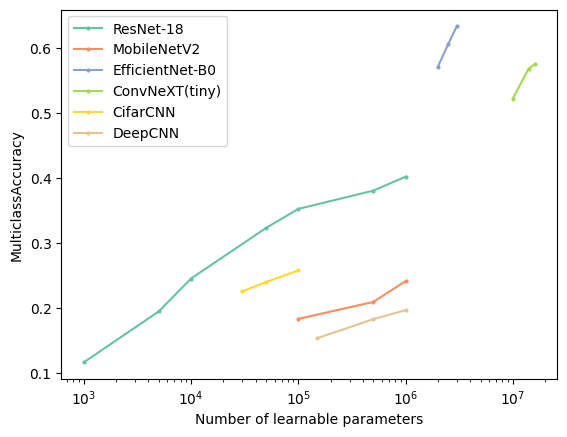

In [66]:
import matplotlib.pyplot as plt

plt.rc('font', family='sans-serif')

indices = list(range(6))
palette_exp = plt.get_cmap('Set2')
colors_exp = {f'{ind:.0f}': palette_exp((i / (len(indices)))) for i,ind in enumerate(indices)}

plt.plot(resnet18_pars,resnet_18_adam,label = 'ResNet-18',marker='o', linestyle='-',markersize=2,color = colors_exp['0'])

plt.plot(mobilenet_v2_pars,mobilenet_v2_adam,label = 'MobileNetV2',marker='o', linestyle='-',markersize=2,color = colors_exp['1'])

plt.plot(efficientnet_pars,efficientnet_model_adam,label = 'EfficientNet-B0',marker='o', linestyle='-',markersize=2,color = colors_exp['2'])

plt.plot(convnext_pars,convnext_adam,label = 'ConvNeXT(tiny)',marker='o', linestyle='-',markersize=2,color = colors_exp['3'])

plt.plot(cifar_cnn_pars,cifar_cnn_adam,label = 'CifarCNN',marker='o', linestyle='-',markersize=2,color = colors_exp['4'])

plt.plot(deep_cnn_pars,deep_cnn_adam,label = 'DeepCNN',marker='o', linestyle='-',markersize=2,color = colors_exp['5'])

plt.xscale('log')
plt.ylabel('MulticlassAccuracy')
plt.xlabel("Number of learnable parameters")
plt.legend()
plt.savefig('contraints_on_params.png',dpi=600)
plt.show()

In [91]:
full_models_output = test_pipeline_full_models([CifarCNN(),DeepCNN(),CustomResnet(),mobilenet_v2,efficientnet_model,model],[
    "cifar_cnn",
    "deep_cnn",
    "resnet18",
    "mobilenet_v2",
    "efficientnet",
    "convnext_model"
])

Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


cifar_cnn
./saved_models/cifar_cnn/adamw/full_model/*/*/model.ckpt


c:\Users\Andruxa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 MulticlassAccuracy/test    0.29930001497268677
 MulticlassF1Score/test     0.2869798243045807
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
deep_cnn
./saved_models/deep_cnn/adamw/full_model/*/*/model.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 MulticlassAccuracy/test    0.4580000042915344
 MulticlassF1Score/test     0.44881051778793335
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
resnet18
./saved_models/resnet18/adamw/full_model/*/*/model.ckpt


Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 MulticlassAccuracy/test    0.6949000358581543
 MulticlassF1Score/test     0.6952316164970398
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
mobilenet_v2
./saved_models/mobilenet_v2/adamw/full_model/*/*/model.ckpt


Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 MulticlassAccuracy/test    0.7136000394821167
 MulticlassF1Score/test     0.7119714021682739
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
efficientnet
./saved_models/efficientnet/adamw/full_model/*/*/model.ckpt


Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 MulticlassAccuracy/test    0.6552000045776367
 MulticlassF1Score/test     0.6523370742797852
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
convnext_model
./saved_models/convnext_model/adamw/full_model/*/*/model.ckpt


Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 MulticlassAccuracy/test    0.7042999863624573
 MulticlassF1Score/test     0.7036000490188599
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [92]:
old_keys = list(full_models_output.keys())
new_keys = [
    "CifarCNN",
    "DeepCNN",
    "ResNet-18",
    "MobileNetV2",
    "EfficientNet-B0",
    "ConvNeXT(tiny)"
    
]

In [93]:
full_models_output = {new_key: full_models_output[old_key] for new_key, old_key in zip(new_keys, full_models_output)}

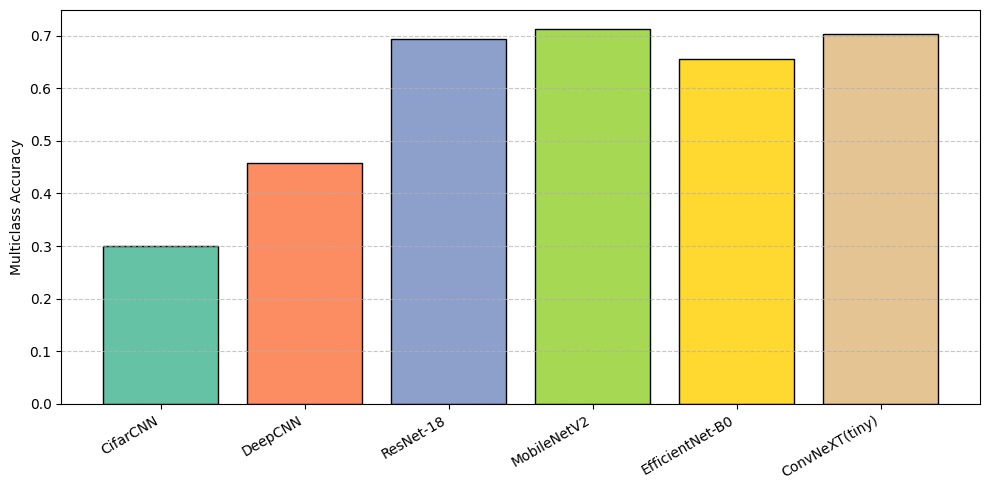

In [98]:
labels = list(full_models_output.keys())
values = list(full_models_output.values())

indices = list(range(6))
palette_exp = plt.get_cmap('Set2')
colors_exp = {f'{labels[ind]}': palette_exp((i / (len(indices)))) for i,ind in enumerate(indices)}
bar_colors = [colors_exp[label] for label in labels]
plt.rc('font', family='sans-serif')
plt.figure(figsize=(10, 5))
plt.bar(labels, values, edgecolor='black',color = bar_colors)
plt.ylabel("Multiclass Accuracy")
plt.xticks(rotation=30, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('full_models.png',dpi=600)
plt.show()

In [97]:
print(full_models_output)

{'CifarCNN': 0.29930001497268677, 'DeepCNN': 0.4580000042915344, 'ResNet-18': 0.6949000358581543, 'MobileNetV2': 0.7136000394821167, 'EfficientNet-B0': 0.6552000045776367, 'ConvNeXT(tiny)': 0.7042999863624573}


In [100]:
for mod,name in zip([CifarCNN(),DeepCNN(),CustomResnet(),mobilenet_v2,efficientnet_model,model],new_keys):
    print(name+':',count_nonzero_parameters_in_layers(mod))

CifarCNN: 194357
DeepCNN: 1750836
ResNet-18: 11208996
MobileNetV2: 2317860
EfficientNet-B0: 4092864
ConvNeXT(tiny): 27870628
